In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from numpy.polynomial.legendre import legvander
import datetime
import utils
%load_ext autoreload
%autoreload 2

In [13]:
df = pd.read_parquet('hourly_liquidity_full.parquet')
dfps = pd.read_parquet('hourly_pool_state_full.parquet')
dfp = pd.read_parquet('hourly_liquidity_pricecentered_full.parquet')

def transform_df(df, centered, TT, TT_end):
    d = df[df.hour > TT]
    d = d[d.hour <= TT_end]
    d["timestamp"] = pd.to_datetime(d["timestamp"], utc=True, unit = 's')
    if centered:
        WINDOW = 50
        d["tick_norm"] = (d["tickLower"].astype(float) - 0.0) / WINDOW
        d["tick_norm"] = d["tick_norm"].clip(-1, 1)
    else:
        WINDOW = 50
        d["tick_norm"] = (d["tickLower"].astype(float) - d['poolTick'].astype(float)) / WINDOW
        d["tick_norm"] = d["tick_norm"].clip(-1, 1)

    # Log liquidity (use log1p to handle zeros)
    d["logL"] = np.log1p(d["active_liquidity_L"].astype(float))
    return d
TT = datetime.datetime(2022,11,1,0, tzinfo=datetime.timezone.utc)
TT_end = dfp.hour.iloc[-1]

d_pegcentered = transform_df(df, centered=True, TT=TT, TT_end=TT_end)
d_pricecentered = transform_df(dfp, centered=False, TT=TT, TT_end=TT_end)


LIQ_COL = "active_liquidity_L"            
Y_pegcentered = (d_pegcentered.pivot_table(index="timestamp", columns="tick_norm", values=LIQ_COL, aggfunc="sum")
       .sort_index()
       .sort_index(axis=1))
Y_pegcentered = Y_pegcentered.fillna(0.0)
Ylog_pegcentered = np.log1p(Y_pegcentered)

Y_pricecentered = (d_pricecentered.pivot_table(index="timestamp", columns="tick_norm", values=LIQ_COL, aggfunc="sum")
       .sort_index()
       .sort_index(axis=1))
Y_pricecentered = Y_pricecentered.fillna(0.0)
Ylog_pricecentered = np.log1p(Y_pricecentered)

# Plot First 5 Legendre polynomials

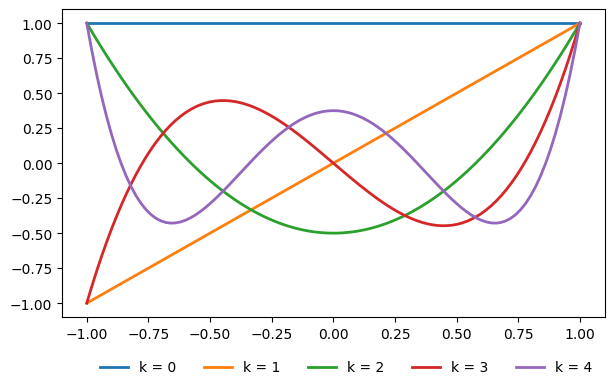

In [14]:
plt.figure(figsize = (7,4))
L = legvander(np.linspace(-1,1, 101),5)
for i in range(5):
    plt.plot(np.linspace(-1,1, 101), L[:,i], label = f'k = {i}', lw = 2)
plt.legend(frameon = False, ncols = 6, bbox_to_anchor = (1,-.1))
plt.savefig('./legendre_first5', dpi = 300, transparent = True, bbox_inches = 'tight')

# Plot projection distance between Legendre and PCA generated subspaces

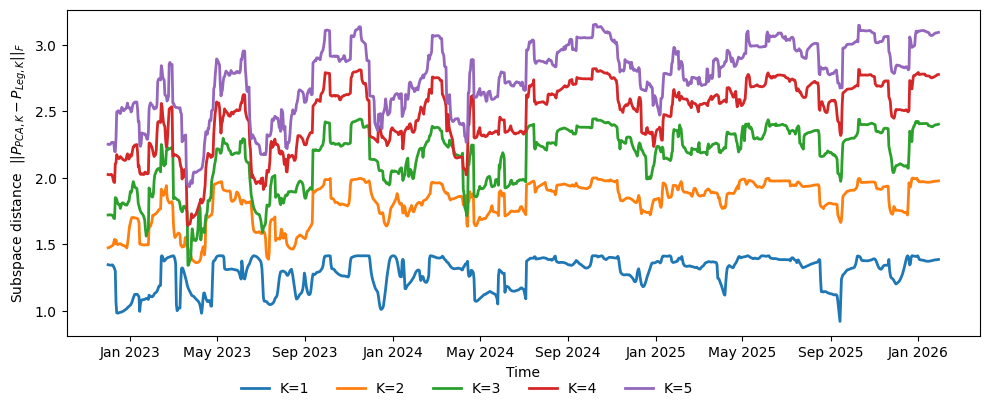

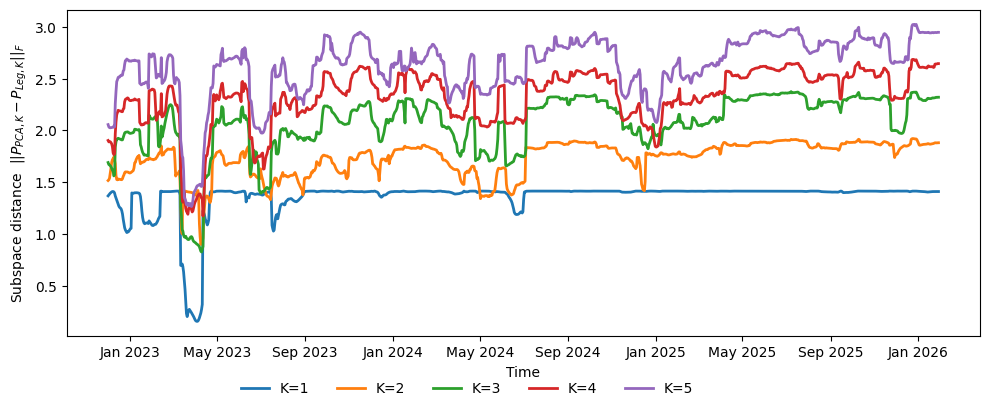

In [15]:
def plot_distance_figure8_style(dist_df, title=''):
    fig, ax = plt.subplots(figsize=(10, 4))
    for K in dist_df.columns:
        ax.plot(dist_df.index, dist_df[K], lw=2, label=f"K={K}")

    ax.set_ylabel(r"Subspace distance  $||P_{PCA,K}-P_{Leg,K}||_F$")
    ax.set_xlabel("Time")
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y", tz=mdates.UTC))
    ax.legend(ncols=3, frameon=True, loc="upper right")
    plt.tight_layout()
    plt.legend(ncols = 5, frameon = False, bbox_to_anchor = (.7,-.1))
    plt.savefig(f'./subspace_distance_{title}', dpi = 300, bbox_inches = 'tight', transparent = True)


Ks = [1, 2, 3, 4, 5]

dist_df_peg = utils.rolling_pca_vs_legendre_distance(
    Ylog=Ylog_pegcentered,
    x_norm=np.linspace(-1, 1, Ylog_pegcentered.shape[1]),
    T=720,
    step=24,
    Ks=Ks,
    metric="projection",
    time_index="end"
)
dist_df_price = utils.rolling_pca_vs_legendre_distance(
    Ylog=Ylog_pricecentered,
    x_norm=np.linspace(-1, 1, Ylog_pricecentered.shape[1]),
    T=720,
    step=24,
    Ks=Ks,
    metric="projection",
    time_index="end"
)

plot_distance_figure8_style(dist_df_peg, title="pegcentered")
plot_distance_figure8_style(dist_df_price, title="pricecentered")

# Plot score time series Legendre dcomposition

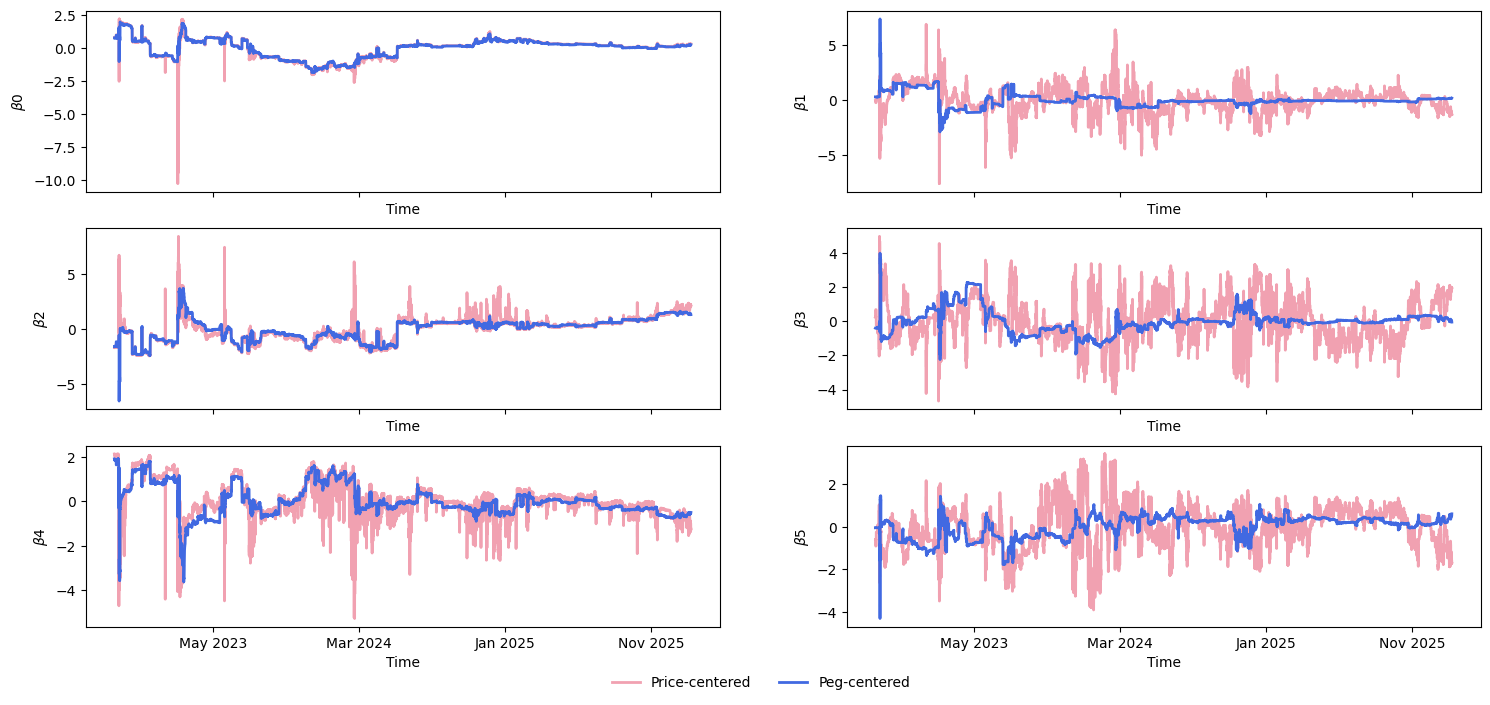

In [43]:
out_price = utils.legendre_scores(Ylog_pricecentered, np.linspace(-1, 1, Ylog_pricecentered.shape[1]), deg=5)
leg_scores_price  = out_price["legendre"]["scores"]   # DataFrame indexed by time, columns deg0..deg5
out_peg = utils.legendre_scores(Ylog_pegcentered, np.linspace(-1, 1, Ylog_pegcentered.shape[1]), deg=5)
leg_scores_peg  = out_peg["legendre"]["scores"]   # DataFrame indexed by time, columns deg0..deg5

fig, axs = plt.subplots(3,2, figsize=(18,8), sharex = True)
axs = axs.ravel()

for i in range(6):
    axs[i].plot(leg_scores_price.index, leg_scores_price.iloc[:,i], label='Price-centered', lw=2, alpha = 0.4, color = 'crimson')
    axs[i].plot(leg_scores_peg.index, leg_scores_peg.iloc[:,i], label='Peg-centered', lw=2, color = 'royalblue')
    # axs[i].set_title(f'Legendre Coefficient Degree {i}')
    axs[i].set_xlabel('Time')
    axs[i].set_ylabel(r'$\beta{}$'.format(i))
    if i == 5:
        axs[i].legend(frameon=False, ncols = 2, bbox_to_anchor=(0.12, -0.2))
        axs[i].xaxis.set_major_formatter(mdates.DateFormatter("%b %Y", tz=mdates.UTC))
        axs[i].xaxis.set_major_locator(plt.MaxNLocator(5))

plt.savefig('./legendre_scores_pegvsprice.png', dpi = 300, transparent = True, bbox_inches = 'tight')

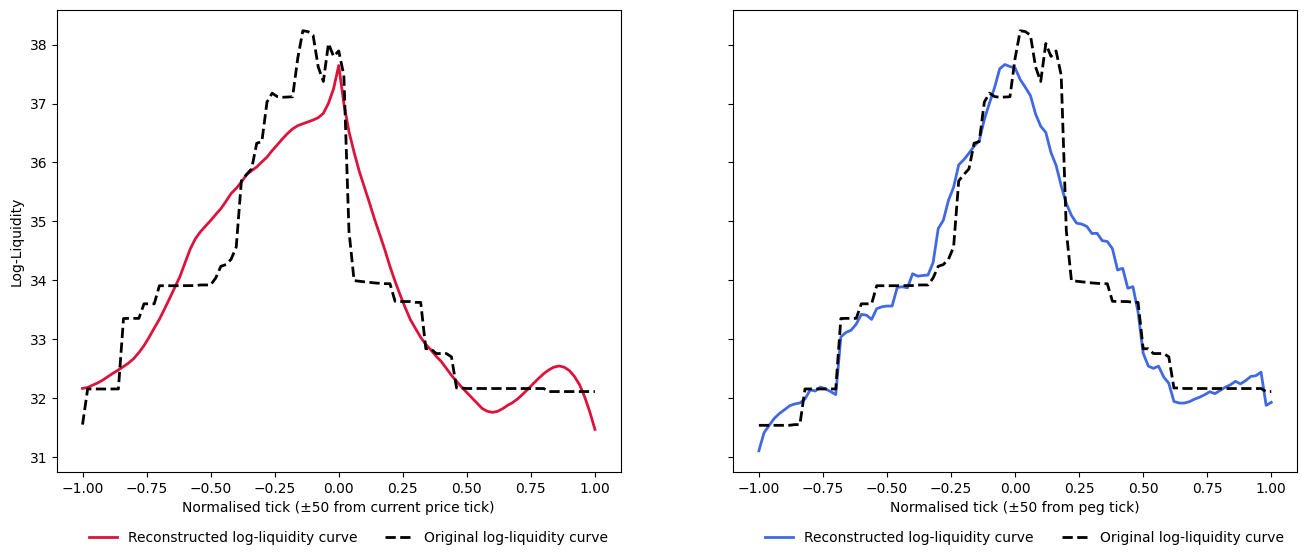

In [42]:
timestamp = datetime.datetime(2026,1,21,10, tzinfo=datetime.timezone.utc)

bs_price = leg_scores_price[leg_scores_price.index == timestamp]
bs_peg = leg_scores_peg[leg_scores_peg.index == timestamp]

fig, axs = plt.subplots(1,2,figsize = (16,6), sharey= True)


axs[0].plot(np.linspace(-1, 1, Ylog_pricecentered.shape[1]), np.dot(bs_price.values.flatten(), out_price["legendre"]["Phi"].T) + out_price["legendre"]["m"], label='Reconstructed log-liquidity curve', lw=2, color = 'crimson')
axs[0].plot(np.linspace(-1, 1, Ylog_pricecentered.shape[1]), Ylog_pricecentered.loc[timestamp].values, label='Original log-liquidity curve', lw=2, ls='--', color = 'black')


axs[1].plot(np.linspace(-1, 1, Ylog_pegcentered.shape[1]), np.dot(bs_peg.values.flatten(), out_peg["legendre"]["Phi"].T) + out_peg["legendre"]["m"], label='Reconstructed log-liquidity curve', lw=2,color = 'royalblue')
axs[1].plot(np.linspace(-1, 1, Ylog_pegcentered.shape[1]), Ylog_pegcentered.loc[timestamp].values, label='Original log-liquidity curve', lw=2, ls='--', color = 'black')
axs[0].set_xlabel('Normalised tick (±50 from current price tick)')
axs[1].set_xlabel('Normalised tick (±50 from peg tick)')
axs[0].set_ylabel('Log-Liquidity')
axs[0].legend(bbox_to_anchor = (1,-0.1), ncols = 2, frameon = False)
axs[1].legend(bbox_to_anchor = (1,-0.1), ncols = 2, frameon = False)
plt.savefig('legendre_reconstruction_pegvsprice.png', dpi = 300, transparent = True, bbox_inches = 'tight')